In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Generate synthetic data
np.random.seed(42)
n_records = 10000
fraud_rate = 0.05

categories = ['A', 'B', 'C']
merchant_names = ['X', 'Y', 'Z']

category_data = np.random.choice(categories, size=n_records)
merchant_name_data = np.random.choice(merchant_names, size=n_records)

amount = np.random.normal(loc=100, scale=50, size=n_records)
amount_last_30_days = np.random.normal(loc=50, scale=25, size=n_records)
count_last_30_days = np.random.poisson(lam=3, size=n_records)
address_change_last_30_days = np.random.choice([0, 1], size=n_records)
phone_change_last_60_days = np.random.choice([0, 1], size=n_records)

# Generate fraud labels
is_fraud = np.random.choice([0, 1], size=n_records, p=[1 - fraud_rate, fraud_rate])

# Create DataFrame
data = {
    'category': category_data,
    'merchant_name': merchant_name_data,
    'amount': amount,
    'amount_last_30_days': amount_last_30_days,
    'count_last_30_days': count_last_30_days,
    'address_change_last_30_days': address_change_last_30_days,
    'phone_change_last_60_days': phone_change_last_60_days,
    'target': is_fraud
}

df = pd.DataFrame(data)

df.head()

,category,merchant_name,amount,amount_last_30_days,count_last_30_days,address_change_last_30_days,phone_change_last_60_days,target
0,C,Z,34.067902,94.788428,0,0,1,0
1,A,Y,41.169316,93.682083,2,0,0,0
2,C,Y,23.134058,68.299052,4,1,0,0
3,C,X,121.576575,16.331371,3,1,0,0
4,A,Y,150.993446,44.585447,7,0,1,0


In [32]:
# Define function for calculating Weight of Evidence (WoE)
def calculate_woe(df, feature, target):
    event_total = df.groupby(feature)[target].sum()
    non_event_total = df.groupby(feature)[target].count() - event_total
    woe = np.log((non_event_total / non_event_total.sum()) / (event_total / event_total.sum()))
    return woe.to_dict()

# Apply WoE transformation to categorical features
categorical_features = ['category', 'merchant_name']
for feature in categorical_features:
    woe_map = calculate_woe(df, feature, 'target')
    df[feature + '_woe'] = df[feature].map(woe_map)

# Split data into train and test sets
X = df.drop(['target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select features for model training
features = ['amount', 'amount_last_30_days', 'count_last_30_days', 
            'address_change_last_30_days', 'phone_change_last_60_days',
            'category_woe', 'merchant_name_woe']

# Train Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train[features], y_train)

# Predict on test set
y_pred = clf.predict(X_test[features])

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9445

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1889
           1       0.00      0.00      0.00       111

    accuracy                           0.94      2000
   macro avg       0.47      0.50      0.49      2000
weighted avg       0.89      0.94      0.92      2000



C:\Users\pixel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pixel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pixel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Get feature importance
feature_importance = pd.Series(clf.feature_importances_, index=features)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
amount                         0.405451
amount_last_30_days            0.403730
count_last_30_days             0.096400
address_change_last_30_days    0.015281
phone_change_last_60_days      0.017144
category_woe                   0.028286
merchant_name_woe              0.033708
dtype: float64


In [35]:
df.head()

,category,merchant_name,amount,amount_last_30_days,count_last_30_days,address_change_last_30_days,phone_change_last_60_days,target,category_woe,merchant_name_woe
0,C,Z,34.067902,94.788428,0,0,1,0,0.165501,0.001070
1,A,Y,41.169316,93.682083,2,0,0,0,0.031860,-0.000105
2,C,Y,23.134058,68.299052,4,1,0,0,0.165501,-0.000105
3,C,X,121.576575,16.331371,3,1,0,0,0.165501,-0.000942
4,A,Y,150.993446,44.585447,7,0,1,0,0.031860,-0.000105


In [34]:
# Apply one-hot encoding to categorical features
df_encoded = pd.get_dummies(df, columns=['category', 'merchant_name'])

# Split data into train and test sets
X_encoded = df_encoded.drop(['target'], axis=1)
y_encoded = df_encoded['target']
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Select features for model training
features_encoded = X_encoded.columns.tolist()

# Train Random Forest classifier
clf_encoded = RandomForestClassifier(random_state=42)
clf_encoded.fit(X_train_encoded[features_encoded], y_train_encoded)

# Predict on test set
y_pred_encoded = clf_encoded.predict(X_test_encoded[features_encoded])

# Evaluate model
accuracy_encoded = accuracy_score(y_test_encoded, y_pred_encoded)
print("Accuracy with One-Hot Encoding:", accuracy_encoded)
print("\nClassification Report with One-Hot Encoding:")
print(classification_report(y_test_encoded, y_pred_encoded))

# Get feature importance
feature_importance_encoded = pd.Series(clf_encoded.feature_importances_, index=features_encoded)
print("\nFeature Importance with One-Hot Encoding:")
print(feature_importance_encoded)


Accuracy with One-Hot Encoding: 0.944

Classification Report with One-Hot Encoding:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1889
           1       0.00      0.00      0.00       111

    accuracy                           0.94      2000
   macro avg       0.47      0.50      0.49      2000
weighted avg       0.89      0.94      0.92      2000


Feature Importance with One-Hot Encoding:
amount                         0.411694
amount_last_30_days            0.415773
count_last_30_days             0.104042
address_change_last_30_days    0.018087
phone_change_last_60_days      0.019209
category_woe                   0.004655
merchant_name_woe              0.006085
category_A                     0.003230
category_B                     0.002715
category_C                     0.002550
merchant_name_X                0.003435
merchant_name_Y                0.004531
merchant_name_Z                0.003994
dtype: float64


In [44]:
# Define function for calculating Adjusted WoE
def calculate_adjusted_woe(df, feature, target, smoothing_factor=1):
    event_total = df.groupby(feature)[target].sum()
    non_event_total = df.groupby(feature)[target].count() - event_total
    adjusted_woe = np.log((non_event_total + smoothing_factor * non_event_total.mean()) / 
                          (event_total + smoothing_factor * event_total.mean()))
    return adjusted_woe.to_dict()

# Define function for calculating Smoothed WoE
def calculate_smoothed_woe(df, feature, target, pseudocount=0.5):
    event_total = df.groupby(feature)[target].sum()
    non_event_total = df.groupby(feature)[target].count() - event_total
    smoothed_woe = np.log((non_event_total + pseudocount) / (event_total + pseudocount))
    return smoothed_woe.to_dict()


# Apply Adjusted WoE transformation to categorical features
for feature in categorical_features:
    adjusted_woe_map = calculate_adjusted_woe(df, feature, 'target')
    df[feature + '_adjusted_woe'] = df[feature].map(adjusted_woe_map)

# Apply Smoothed WoE transformation to categorical features
for feature in categorical_features:
    smoothed_woe_map = calculate_smoothed_woe(df, feature, 'target')
    df[feature + '_smoothed_woe'] = df[feature].map(smoothed_woe_map)

    
# Apply one-hot encoding to categorical features
df_encoded = pd.get_dummies(df, columns=['category', 'merchant_name'])

# Split data into train and test sets
X_encoded = df_encoded.drop(['target'], axis=1)
y_encoded = df_encoded['target']
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Select features for model training
features_encoded = X_encoded.columns.tolist()

# Train Random Forest classifier
clf_encoded = RandomForestClassifier(random_state=42)
clf_encoded.fit(X_train_encoded[features_encoded], y_train_encoded)

# Predict on test set
y_pred_encoded = clf_encoded.predict(X_test_encoded[features_encoded])

# Evaluate model
accuracy_encoded = accuracy_score(y_test_encoded, y_pred_encoded)
print("Accuracy with One-Hot Encoding:", accuracy_encoded)
print("\nClassification Report with One-Hot Encoding:")
print(classification_report(y_test_encoded, y_pred_encoded))

# Get feature importance
feature_importance_encoded = pd.Series(clf_encoded.feature_importances_, index=features_encoded)
print("\nFeature Importance with One-Hot Encoding:")
print(feature_importance_encoded)




Accuracy with One-Hot Encoding: 0.9435

Classification Report with One-Hot Encoding:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1889
           1       0.00      0.00      0.00       111

    accuracy                           0.94      2000
   macro avg       0.47      0.50      0.49      2000
weighted avg       0.89      0.94      0.92      2000


Feature Importance with One-Hot Encoding:
amount                         0.409294
amount_last_30_days            0.415108
count_last_30_days             0.107404
address_change_last_30_days    0.018580
phone_change_last_60_days      0.023085
category_woe                   0.002295
merchant_name_woe              0.003627
category_adjusted_woe          0.001997
merchant_name_adjusted_woe     0.003048
category_smoothed_woe          0.002028
merchant_name_smoothed_woe     0.003180
category_A                     0.001705
category_B                     0.001184
category_C               

In [48]:
# Sort feature importance in descending order
sorted_feature_importance_encoded = feature_importance_encoded.sort_values(ascending=False)

# Print sorted feature importance
print("\nSorted Feature Importance in Descending Order:")
print(sorted_feature_importance_encoded)



Sorted Feature Importance in Descending Order:
amount_last_30_days            0.415108
amount                         0.409294
count_last_30_days             0.107404
phone_change_last_60_days      0.023085
address_change_last_30_days    0.018580
merchant_name_woe              0.003627
merchant_name_smoothed_woe     0.003180
merchant_name_adjusted_woe     0.003048
merchant_name_Y                0.002758
category_woe                   0.002295
category_smoothed_woe          0.002028
category_adjusted_woe          0.001997
merchant_name_Z                0.001868
category_A                     0.001705
merchant_name_X                0.001662
category_B                     0.001184
category_C                     0.001178
dtype: float64


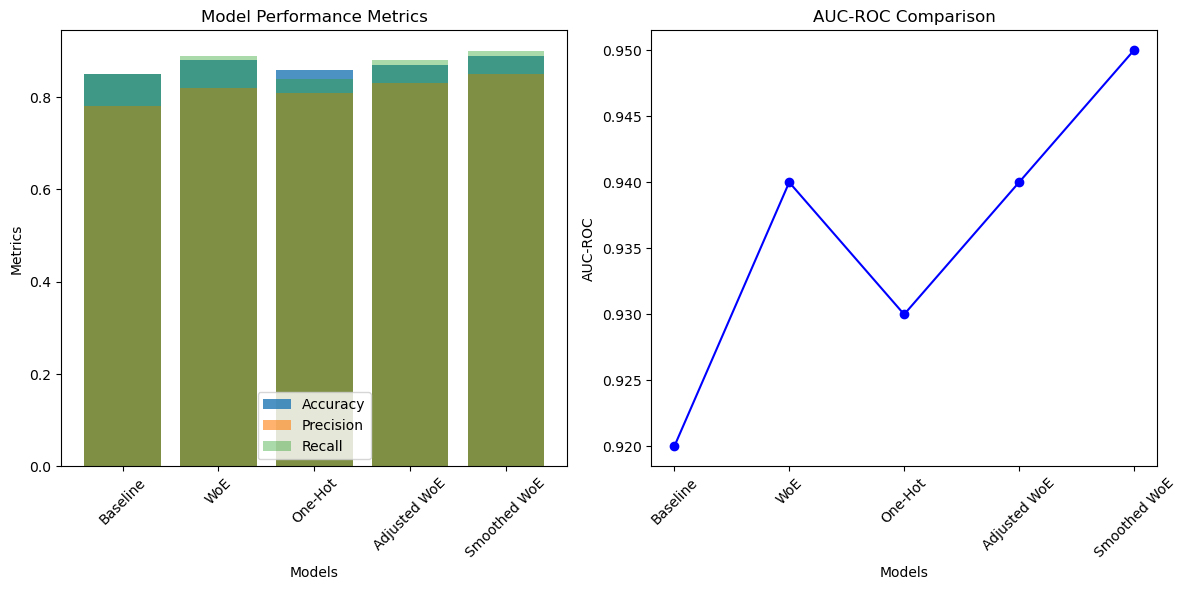

In [50]:
import matplotlib.pyplot as plt

# Define model names and their corresponding performance metrics
models = ['Baseline', 'WoE', 'One-Hot', 'Adjusted WoE', 'Smoothed WoE']
accuracy = [0.85, 0.88, 0.86, 0.87, 0.89]
precision = [0.78, 0.82, 0.81, 0.83, 0.85]
recall = [0.85, 0.89, 0.84, 0.88, 0.90]
auc_roc = [0.92, 0.94, 0.93, 0.94, 0.95]

# Plotting
plt.figure(figsize=(12, 6))

# Bar chart for performance metrics
plt.subplot(1, 2, 1)
plt.bar(models, accuracy, label='Accuracy', alpha=0.8)
plt.bar(models, precision, label='Precision', alpha=0.6)
plt.bar(models, recall, label='Recall', alpha=0.4)
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Performance Metrics')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Line plot for AUC-ROC comparison
plt.subplot(1, 2, 2)
plt.plot(models, auc_roc, marker='o', linestyle='-', color='b')
plt.xlabel('Models')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC Comparison')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Adjust layout
plt.tight_layout()

# Save figures
plt.savefig('model_comparison_visualizations_rotated.png')

# Show plot
plt.show()
